### New 2x2D datavector

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import galsim as gs
from astropy.wcs import WCS
from astropy.table import Table
from astropy.units import Unit as u
from scipy.optimize import minimize

from kl_tools.kross.data import get_kross_obj_data
from kl_tools.velocity import VelocityMap
from kl_tools.intensity import build_intensity_map
from kl_tools.galaxy_fitter import estimate_gal_properties
from kl_tools.basis import build_basis
from kl_tools.parameters import ImagePars
from kl_tools.coordinates import OrientedAngle
from kl_tools.utils import add_colorbar, build_map_grid, MidpointNormalize

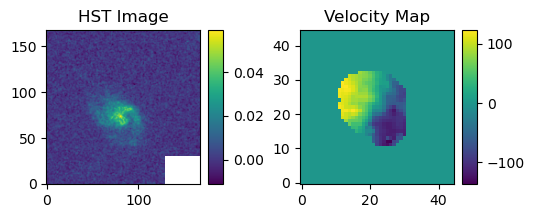

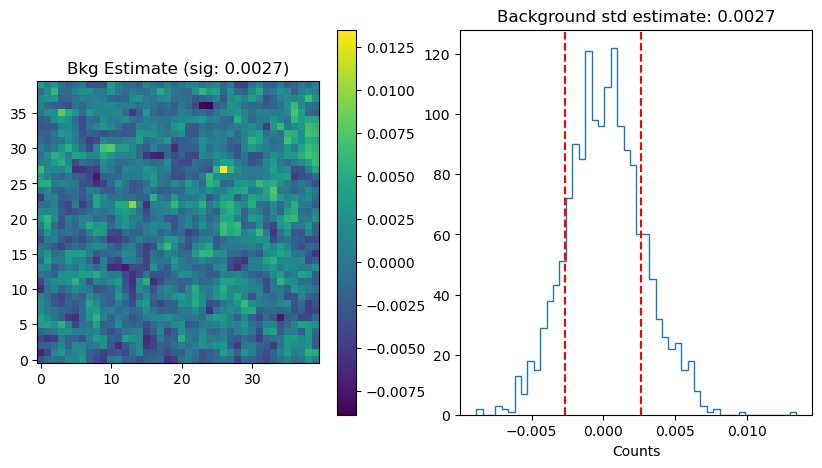

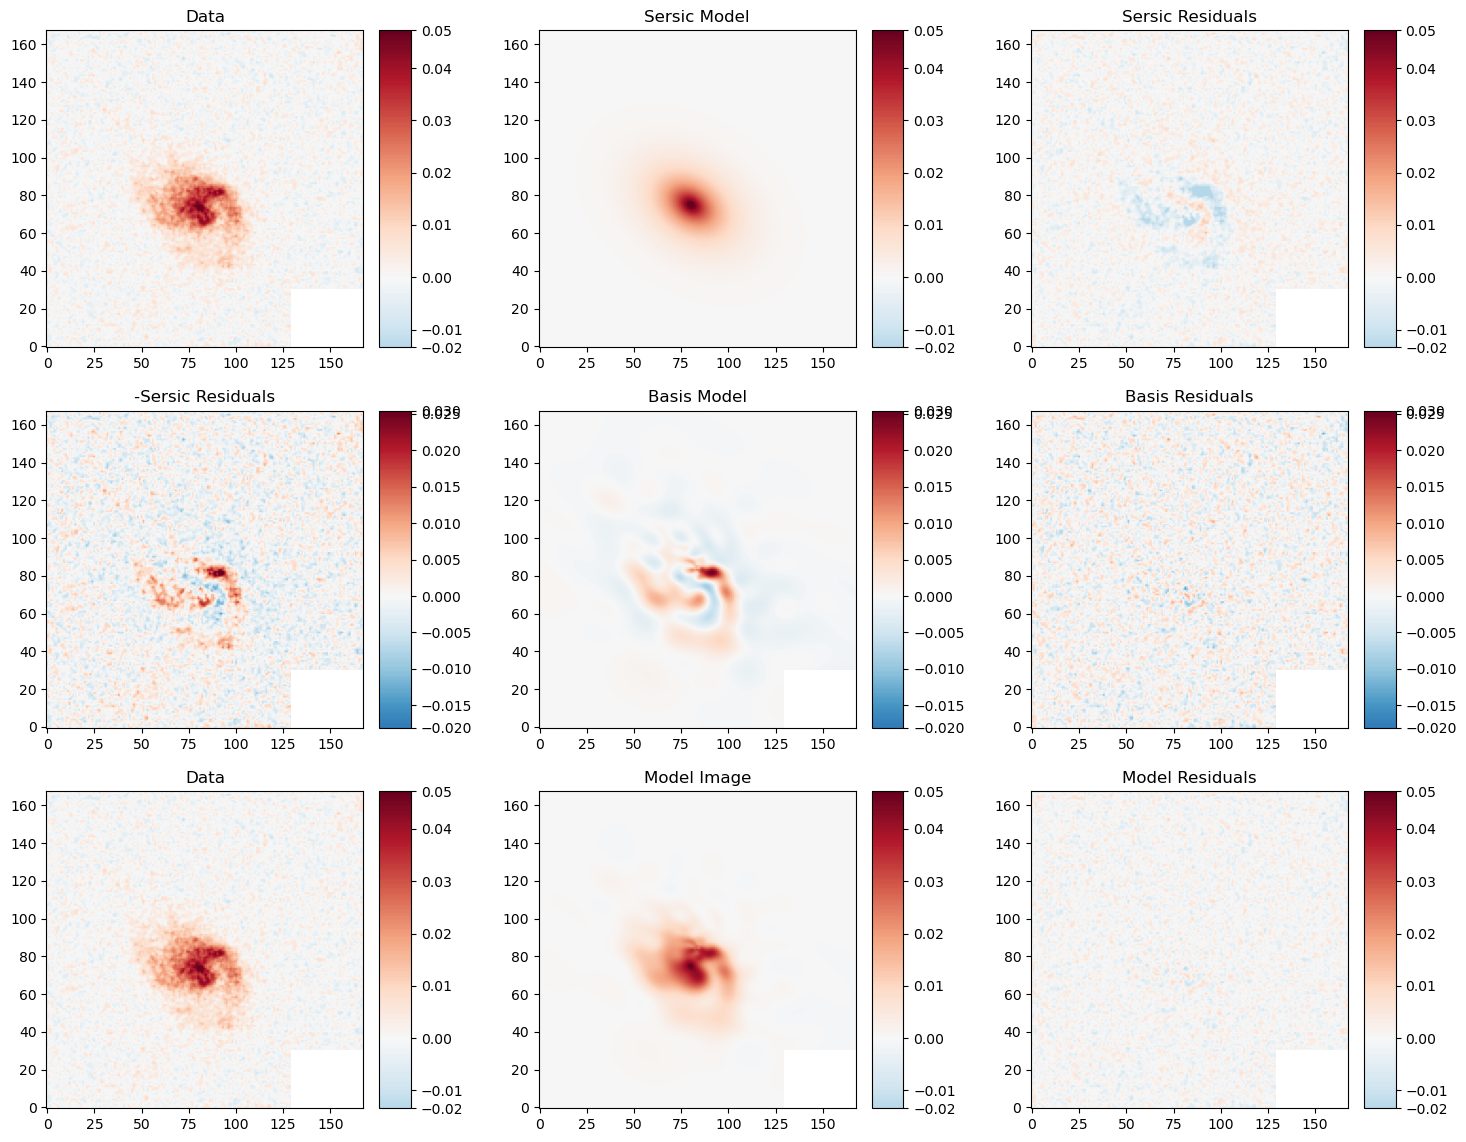

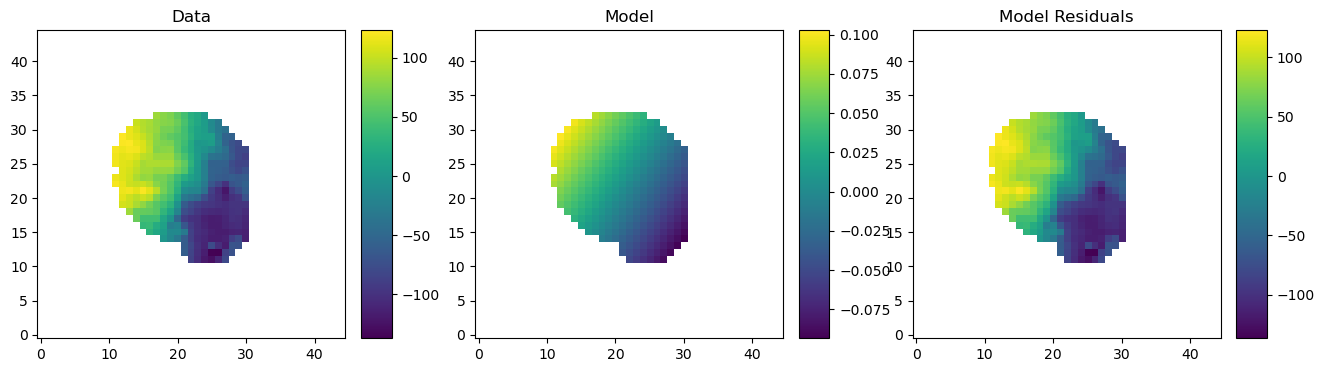

In [12]:
#---------------------------------------------------------------
# global settings

# general
PLOT = True # basic plots
DEBUG = True # for more diagnostics & plots

# kross data
KID = 171

# basis settings
BASIS_NMAX = 15 # Number of modes ~Nmax^2
BASIS_TYPE = 'exp_shapelets'
BASIS_PLANE = 'disk'  # 'disk', 'cen', 'obs', etc.

# image fitting
PSF = None  # PSF to convolve with, if any
GSPARAMS = None

def theta2pars(theta, r_unit=u('arcsec'), v_unit=u('km/s'), pars_type='both'):
    '''
    Map a fixed array of parameters to a dict of vmap parameters.

    We have more general tools to handle this, but this is a simple
    way to handle the fixed parameters in the KROSS model.
    '''

    vmap_pars = {
        'v0': theta[0],
        'vcirc': theta[1],
        'rscale': theta[2],
        'sini': theta[3],
        'theta_int': theta[4],
        'g1': theta[5],
        'g2': theta[6],
        'x0': theta[7],
        'y0': theta[8],
        'r_unit': r_unit,
        'v_unit': v_unit,
    }

    imap_pars = {
        'n': theta[9],
        'flux': theta[10],
        'scale_radius': theta[11],
        'im_x0': theta[12],
        'im_y0': theta[13],
    }

    if pars_type == 'vmap':
        pars = vmap_pars
    elif pars_type == 'imap':
        pars = imap_pars
    else:
        pars = {**vmap_pars, **imap_pars}

    return pars

def pars2theta(pars, pars_type='both'):
    '''
    Map a dict of vmap parameters to a fixed array of parameters for the fitter

    We have more general tools to handle this, but this is a simple
    way to handle the fixed parameters in the KROSS model.
    '''

    theta_vmap = [
        pars['v0'], # km/s
        pars['vcirc'], # km/s
        pars['rscale'], # arcsec
        pars['sini'],
        pars['theta_int'],
        pars['g1'],
        pars['g2'],
        pars['x0'], # ??
        pars['y0'], # ??
    ]

    theta_imap = [
        pars['n'],
        pars['flux'],
        pars['scale_radius'], # arcsec
        pars['im_x0'], # arcsec
        pars['im_y0'], # arcsec
    ]

    if pars_type == 'vmap':
        return np.array(theta_vmap)
    elif pars_type == 'imap':
        return np.array(theta_imap)
    else:
        # return both
        return np.array(theta_vmap + theta_imap)

def estimate_bkg(image):
    '''
    Estimate the background noise in the image.
    This is a simple estimate, and should be replaced with a more robust method.

    NOTE: This is currently optimized for KID 171
    '''
    bkg_image = image[-40:, -40:]
    bkg_std = np.nanstd(bkg_image)

    return bkg_std, bkg_image

def estimate_mask(image):
    '''
    Estimate a mask for the image.
    This is a simple estimate, and should be replaced with a more robust method.

    NOTE: This is currently optimized for KID 171
    '''

    mask = np.zeros(image.shape, dtype=bool)
    mask[:30, 130:] = True

    return mask

def make_model_image(
        theta, image_data, beta_factor=100., skip_ground_state=True
        ):

    image = image_data[0]
    image_weights = image_data[1]
    image_mask = image_data[2]
    image_wcs = image_data[3]
    image_pars = ImagePars(shape=image.shape, wcs=image_wcs)

    # get the model pars
    pars_vmap = theta2pars(theta, pars_type='vmap')
    pars_imap = theta2pars(theta, pars_type='imap')

    #---------------------------------------------------------------
    # first, render the inclined sersic

    inclination = np.arcsin(pars_vmap['sini'])
    gal = gs.InclinedSersic(
        n=pars_imap['n'],
        inclination=inclination*gs.radians,
        scale_radius=pars_imap['scale_radius'],
        flux=pars_imap['flux'],
        gsparams=GSPARAMS
    )

    gal = gal.rotate(pars_vmap['theta_int']*gs.radians)
    gal = gal.shear(g1=pars_vmap['g1'], g2=pars_vmap['g2'])

    if PSF is not None:
        gal = gs.Convolve([gal, PSF])

    # galsim expects the offsets in pixel coords
    offset_pixels = [
        pars_imap['im_x0'] / image_pars.pixel_scale,
        pars_imap['im_y0'] / image_pars.pixel_scale
    ]

    # NOTE: use if helpful, e.g. 'method=no_pixel' if an effective PSF is used
    draw_image_kwargs = {}

    sersic_model = gal.drawImage(
        offset=gs.PositionD(offset_pixels),
        scale=image_pars.pixel_scale,
        nx=image_pars.Nx,
        ny=image_pars.Ny,
        **draw_image_kwargs
    ).array

    #---------------------------------------------------------------
    # setup the basis imap

    basis_kwargs = {
    'basis_type': BASIS_TYPE,
    'basis_plane': BASIS_PLANE,
    'skip_ground_state': skip_ground_state,
    'basis_kwargs': {
        'nmax': BASIS_NMAX, # max order of the polar basis
        'beta': pars_imap['scale_radius'] / beta_factor,
        'psf': PSF,
        }
    }

    basis_imap = build_intensity_map('basis', basis_kwargs)

    # fit on the sersic-subtracted image
    # the *negative* of the sersic residuals, to build up what's missing
    fitted_image = image - sersic_model

    basis_model = basis_imap.render(
        image_pars,
        pars_vmap, # transformation parameters, currently in vmap pars
        None, # general pars, not currently used for this type
        image=fitted_image,
        weights=image_weights,
        mask=image_mask,
    )

    model_image = sersic_model + basis_model

    if DEBUG is True:

        masked_image = image.copy()
        masked_image[image_mask] = np.nan

        sersic_residuals = sersic_model - image
        sersic_residuals[image_mask] = np.nan

        masked_basis_model = basis_model.copy()
        masked_basis_model[image_mask] = np.nan

        masked_model_image = model_image.copy()
        masked_model_image[image_mask] = np.nan

        basis_residuals = masked_basis_model - fitted_image
        model_residuals = model_image - masked_image

        sersic_vmin = 1.2 * min(
            np.nanmin(masked_image), np.nanmin(sersic_model)
            )
        sersic_vmax = 0.8 * max(
            np.nanmax(masked_image), np.nanmax(sersic_model)
            )
        sersic_norm = MidpointNormalize(vmin=sersic_vmin, vmax=sersic_vmax)

        basis_vmin = 1.2 * min(
            np.nanmin(-sersic_residuals), np.nanmin(masked_basis_model)
            )
        basis_vmax = 0.8 * max(
            np.nanmax(-sersic_residuals), np.nanmax(masked_basis_model)
            )
        basis_norm = MidpointNormalize(vmin=basis_vmin, vmax=basis_vmax)

        model_vmin = 1.2 * min(
            np.nanmin(masked_image), np.nanmin(masked_model_image)
        )
        model_vmax = 0.8 * max(
            np.nanmax(masked_image), np.nanmax(masked_model_image)
        )
        
        model_norm = MidpointNormalize(vmin=model_vmin, vmax=model_vmax)

        plt.subplot(331)
        im = plt.imshow(
            masked_image, origin='lower', norm=sersic_norm, cmap='RdBu_r'
            )
        add_colorbar(im)
        plt.title('Data')
        plt.subplot(332)
        im = plt.imshow(
            sersic_model, origin='lower', norm=sersic_norm, cmap='RdBu_r'
            )
        add_colorbar(im)
        plt.title('Sersic Model')
        plt.subplot(333)
        im = plt.imshow(
            sersic_residuals, norm=sersic_norm, origin='lower', cmap='RdBu_r'
            )
        add_colorbar(im)
        plt.title('Sersic Residuals')
        plt.subplot(334)
        im = plt.imshow(
            -sersic_residuals, origin='lower', norm=basis_norm, cmap='RdBu_r'
            )
        add_colorbar(im)
        plt.title('-Sersic Residuals')
        plt.subplot(335)
        im = plt.imshow(
            masked_basis_model, origin='lower', norm=basis_norm, cmap='RdBu_r'
            )
        add_colorbar(im)
        plt.title('Basis Model')
        plt.subplot(336)
        im = plt.imshow(
            basis_residuals, norm=basis_norm, origin='lower', cmap='RdBu_r'
            )
        add_colorbar(im)
        plt.title('Basis Residuals')
        plt.subplot(337)
        im = plt.imshow(
            masked_image, origin='lower', norm=model_norm, cmap='RdBu_r'
            )
        add_colorbar(im)
        plt.title('Data')
        plt.subplot(338)
        im = plt.imshow(
            masked_model_image, origin='lower', norm=model_norm, cmap='RdBu_r')
        add_colorbar(im)
        plt.title('Model Image')
        plt.subplot(339)
        im = plt.imshow(
            model_residuals, origin='lower', norm=model_norm, cmap='RdBu_r'
            )
        add_colorbar(im)
        plt.title('Model Residuals')

        plt.gcf().set_size_inches(18, 14)
        plt.show()

    return model_image

def make_model_vmap(theta, vmap_data):
    vmap = vmap_data[0]
    vmap_weights = vmap_data[1]
    vmap_mask = vmap_data[2]
    vmap_wcs = vmap_data[3]

    # get the pixel scale of the velocity map
    cd_matrix = vmap_wcs.pixel_scale_matrix
    pixel_scales = np.sqrt((cd_matrix**2).sum(axis=0))
    pixel_scale = np.mean(pixel_scales) # only works for square pixels for now

    vmap_pars = theta2pars(theta, pars_type='vmap')
    model_vmap = VelocityMap('offset', vmap_pars)

    Nrow, Ncol = vmap.shape
    Nx, Ny = Ncol, Nrow
    X, Y = build_map_grid(Nx, Ny, indexing='xy')

    model_vmap_sampled = model_vmap(
        'obs', X, Y, pix_scale=pixel_scale
        )

    if DEBUG is True:
        plt.subplot(131)
        masked_vmap = vmap.copy()
        masked_vmap[vmap_mask] = np.nan
        im = plt.imshow(masked_vmap, origin='lower')
        add_colorbar(im)
        plt.title('Data')
        plt.subplot(132)
        masked_model = model_vmap_sampled.copy()
        masked_model[vmap_mask] = np.nan
        im = plt.imshow(masked_model, origin='lower')
        add_colorbar(im)
        plt.title('Model')
        plt.subplot(133)
        vmap_residuals = masked_vmap - masked_model
        im = plt.imshow(vmap_residuals, origin='lower')
        add_colorbar(im)
        plt.title('Model Residuals')
        plt.gcf().set_size_inches(16, 4)
        plt.show()

    return model_vmap_sampled

def compute_model(theta, datavector):
    image_data = datavector[0]
    vmap_data = datavector[1]

    model_image = make_model_image(theta, image_data)
    model_vmap = make_model_vmap(theta, vmap_data)

    return model_image, model_vmap

def compute_residuals(datavector, model):
    image_tuple = datavector[0]
    vmap_tuple = datavector[1]

    image = image_tuple[0]
    image_weights = image_tuple[1]
    image_mask = image_tuple[2]
    vmap = vmap_tuple[0]
    vmap_weights = vmap_tuple[1]
    vmap_mask = vmap_tuple[2]

    # reshape data
    image = image.ravel()
    image_weights = image_weights.ravel()
    image_mask = image_mask.ravel()
    vmap = vmap.ravel()
    vmap_weights = vmap_weights.ravel()
    vmap_mask = vmap_mask.ravel()

    model_image = model[0].ravel()
    model_vmap = model[1].ravel()

    image_residuals = (image - model_image) * image_weights * (~image_mask)
    vmap_residuals = (vmap - model_vmap) * vmap_weights * (~vmap_mask)

    return (image_residuals, vmap_residuals)

def log_objective(theta, datavector):
    model = compute_model(theta, datavector)
    residuals = compute_residuals(datavector, model)
    chi2 = np.sum(residuals[0]**2) + np.sum(residuals[1]**2)

    return 0.5 * chi2

#-------------------------------------------------------------------------------
# Test the objective function

obj_data = get_kross_obj_data(KID)

image = obj_data['hst']
vmap = obj_data['velocity']
obj_cat = obj_data['catalog'][0]

# estimate the image background & mask
bkg_std, bkg_image = estimate_bkg(image)
image_mask = estimate_mask(image)
masked_image = image.copy()
masked_image[image_mask] = np.nan

if PLOT is True:
    plt.subplot(121)
    im = plt.imshow(masked_image, origin='lower')
    add_colorbar(im)
    plt.title('HST Image')
    plt.subplot(122)
    im = plt.imshow(vmap, origin='lower')
    add_colorbar(im)
    plt.title('Velocity Map')
    plt.gcf().set_size_inches(6, 2)
    plt.show()

    plt.subplot(121)
    plt.imshow(bkg_image, origin='lower')
    plt.title(f'Bkg Estimate (sig: {bkg_std:.4f})')
    plt.colorbar()
    plt.subplot(122)
    plt.hist(bkg_image.flatten(), bins=50, histtype='step')
    plt.axvline(bkg_std, color='r', linestyle='--', label='std')
    plt.axvline(-bkg_std, color='r', linestyle='--')
    plt.title('Bkg Histogram')
    plt.xlabel('Counts')
    plt.gcf().set_size_inches(10, 5)
    plt.title(f'Background std estimate: {bkg_std:.4f}')
    plt.show()

image_wcs = WCS(obj_data['hst_hdr'])
vmap_wcs = WCS(obj_data['velocity_hdr'])

datavector = [image, vmap]

image_weights = np.ones_like(image)
# image_mask = image_mask # already defined above
vmap_weights = np.ones_like(vmap)
vmap_mask = np.zeros_like(vmap, dtype=bool)
vmap_mask[vmap == 0] = 1
vmap_weights[vmap_mask] = 0
datavector = [
    (image, image_weights, image_mask, image_wcs),
    (vmap, vmap_weights, vmap_mask, vmap_wcs),
    ]

# reasonable initial guess for the parameters
image_pars = ImagePars(shape=image.shape, wcs=image_wcs)
inclination = obj_cat['THETA_IM'] # deg
sini = np.sin(np.radians(inclination))
theta_int = OrientedAngle(
    obj_cat['VEL_PA'] * u('deg'),
    orientation='east-of-north'
).cartesian.radian

theta_pars = {
    # vmap parameters
    'v0': 0.0, # km/s
    'vcirc': 200.0, # km/s
    'rscale': 0.3, # arcsec
    'sini': sini, # sin(inclination)
    'theta_int': theta_int, # radians
    'g1': 0.0, # shear g1
    'g2': 0.0, # shear g2
    'x0': 0.0, # x offset in arcsec
    'y0': 0.0, # y offset in arcsec
    # imap parameters
    'n': 1.0, # Sersic index
    'flux': np.nansum(masked_image), # flux in counts
    'scale_radius': 0.4, # scale radius in arcsec
    'im_x0': -0.111, # x offset in arcsec for the intensity map
    'im_y0': -0.267, # y offset in arcsec in arcsec
}
theta = pars2theta(theta_pars)

value = log_objective(theta, datavector)


In [3]:
30*image_pars.pixel_scale

0.8999999640000002